In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import json
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
with open("intents.json") as file:
    pattern = json.load(file)

responses = pattern['responses']
patterns = np.array(pattern['intents'])
patterns = patterns.T

data = patterns[0]
target = patterns[1]

In [4]:
train_txt,test_txt,train_label,test_labels = train_test_split(data,target,test_size = 0.3)
val_txt, test_txt, val_label, test_labels = train_test_split(test_txt, test_labels, test_size=0.3, shuffle=True)

In [6]:
print(train_txt.shape)
print(val_txt.shape)
print(test_txt.shape)

(1499,)
(450,)
(193,)


In [8]:
max_num_words = 40000

classes = np.unique(target)

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train_txt)
word_index = tokenizer.word_index

In [9]:
ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))
print(train_txt)
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')
val_sequences = tokenizer.texts_to_sequences(val_txt)
val_sequences = pad_sequences(val_sequences, maxlen=maxLen, padding='post')
test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

['thanks for your cooperation' 'can you tell me something funny'
 'what am i allowed to ask you' ... 'i love dad jokes can you tell me one'
 'what kind of movie' 'tell me a joke about cows']


In [10]:
label_encoder = LabelEncoder()

integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)

train_label_encoded = label_encoder.transform(train_label)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)
val_label_encoded = label_encoder.transform(val_label)
val_label_encoded = val_label_encoded.reshape(len(val_label_encoded), 1)
val_label = onehot_encoder.transform(val_label_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)

In [11]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [12]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

c:\users\berka\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.25))
model.add(LSTM(512, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(classes.shape[0], activation='softmax'))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           73600     
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 512)           731136    
_________________________________________________________________
dropout (Dropout)            (None, 11, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_sequences, train_label, epochs = 15,
          batch_size = 64, shuffle=True,
          validation_data=(val_sequences, val_label))

Epoch 1/15
24/24 [==============================] - 27s 759ms/step - loss: 2.8034 - accuracy: 0.1219 - val_loss: 2.4277 - val_accuracy: 0.2378
Epoch 2/15
24/24 [==============================] - 17s 688ms/step - loss: 2.2815 - accuracy: 0.2576 - val_loss: 1.6158 - val_accuracy: 0.4200
Epoch 3/15
24/24 [==============================] - 17s 713ms/step - loss: 1.6463 - accuracy: 0.4042 - val_loss: 1.1491 - val_accuracy: 0.5711
Epoch 4/15
24/24 [==============================] - 20s 862ms/step - loss: 1.1837 - accuracy: 0.5580 - val_loss: 1.0678 - val_accuracy: 0.6111
Epoch 5/15
24/24 [==============================] - 19s 784ms/step - loss: 1.0976 - accuracy: 0.6121 - val_loss: 0.8525 - val_accuracy: 0.6822
Epoch 6/15
24/24 [==============================] - 20s 831ms/step - loss: 0.9236 - accuracy: 0.6679 - val_loss: 0.7741 - val_accuracy: 0.7444
Epoch 7/15
24/24 [==============================] - 22s 921ms/step - loss: 0.7245 - accuracy: 0.7627 - val_loss: 0.6845 - val_accuracy: 0.7756

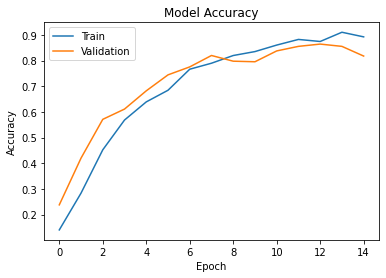

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

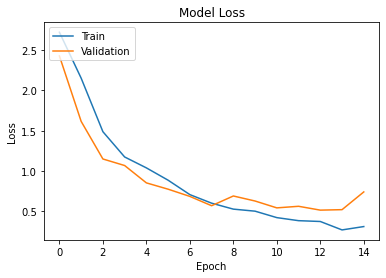

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
model.save('intent_model/intents.h5')

with open('intent_model/classes.pkl','wb') as file:
    pickle.dump(classes,file)

with open('intent_model/tokenizer.pkl','wb') as file:
    pickle.dump(tokenizer,file)

with open('intent_model/label_encoder.pkl','wb') as file:
    pickle.dump(label_encoder,file)

model = load_model('intent_model/intents.h5')

with open('intent_model/classes.pkl','rb') as file:
    classes = pickle.load(file)

with open('intent_model/tokenizer.pkl','rb') as file:
    tokenizer = pickle.load(file)

with open('intent_model/label_encoder.pkl','rb') as file:
    label_encoder = pickle.load(file)